## Microsoft Model
This notebook is the seperate implementation on the microsoft stocks data. It is made in following manner:
1. Import Libraries
2. Read and process the data
    - Normalize the data
    - Polymerize data
    - Split into training and testing
    - change dimentions
3. Implement the Baseline model
    - Make model
    - Train model
    - Predict on test data
    - Calculate score and make prediction graph
3. Make Final model
    - Make and compile model 
    - Train model using Simple training
    - Predict on test data
    - Calculate score and make prediction graph
    - Train model using Framed training
    - Predict on test data
    - Calculate score and make prediction graph

## Import lib

In [2]:
# get all the imports
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras import optimizers

import tensorflow as tf

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

Using TensorFlow backend.
/Users/batman/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Read the datafile

change the directory if needed

In [ ]:
cd Data

#### Read the file using pandas and preprocess it 

In [59]:
micro=pd.read_csv('MicrosoftFinalData.csv')
# process the colums of the file
micro=micro.rename(columns={'Adj Close':'Price'})   # reaname the column
micro=micro.drop('Close',axis=1)                    # remove the unused column
micro['Month']=int                                  # add a blank month column in the data field

# add the data into the month column, it will take time
for i in range(len(micro)):
  micro['Month'][i]=int(micro['Date'][i].split('-')[1])

# arrange the final sequence of column
micro=micro[['Open', 'High', 'Low', 'compound', 'neg', 'neu', 'pos','Month','Date','Price']]   
micro.columns   # check the finla output

/Users/batman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Index(['Open', 'High', 'Low', 'compound', 'neg', 'neu', 'pos', 'Month', 'Date',
       'Price'],
      dtype='object')

#### Split the data into news and stocks

** Only the Opening price of the stock is taken.

In [60]:
stock=micro.iloc[:,:1].values
news=micro.iloc[0:,3:7].values

#### Normalise the stock data

In [61]:
stock=(stock-np.min(stock))/(np.max(stock)-np.min(stock))

####  Polymerise Stock data

since we are using only one data coloumn form stock

In [62]:
# to make polynomial feature set
poly=PolynomialFeatures(degree=2)
stock=poly.fit_transform(stock)

#### Split the train and test data set

In [63]:
train_x= np.hstack([stock[:2033,1:],news[:2033]])
train_y= micro.iloc[:2033,9:].values

test_x= np.hstack([stock[2033:,1:],news[2033:]])
test_y= micro.iloc[2033:,9:].values

#### Reshape the input feature set for LSTM

In [64]:
# reshape the data acording to the lstm
train_x=train_x.reshape(train_x.shape[:1][0],1,6)
test_x=test_x.reshape(484,1,6)

### Baseline Model

In [65]:
# make model
model=Sequential()

# layer 1
model.add(LSTM(128,input_shape=(1,train_x.shape[2:][0]),activation='relu', return_sequences=True ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 2
model.add(LSTM(128, return_sequences=True ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 3
model.add(LSTM(128, activation='relu',return_sequences=False ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 4
model.add(Dense(100,activation='relu' ))
model.add(Dropout(0.3))
model.add(BatchNormalization())
# layer 5
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 6
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# final output in 1
model.add(Dense(1))

# make optimiser
opt=keras.optimizers.RMSprop(lr=0.001,rho=0.9, decay=0.0)
# compile the model
model.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])

# for the tensorboard log file
time=datetime.now()
tbCallBack = keras.callbacks.TensorBoard(log_dir='/log/micro'+str(time), write_graph=True)

# for model checkpoints
filepath="micro_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint,tbCallBack]

In [66]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 1, 128)            69120     
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 1, 128)            512       
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 128)            131584    
_________________________________________________________________
dropout_20 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 1, 128)            512       
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               131584    
__________

#### Train the baseline model

In [51]:
model.fit(
        train_x
        ,train_y
        , epochs=30
        ,batch_size=10
    
        ,verbose=1
        ,validation_split=0.1 
        ,callbacks=callbacks_list
        )

Train on 1829 samples, validate on 204 samples
Epoch 1/30
1829/1829 [==============================] - 7s 4ms/step - loss: 722.6885 - acc: 0.0000e+00 - val_loss: 1625.9425 - val_acc: 0.0000e+00
Epoch 2/30
1829/1829 [==============================] - 4s 2ms/step - loss: 474.5172 - acc: 0.0000e+00 - val_loss: 1034.1571 - val_acc: 0.0000e+00
Epoch 3/30
1829/1829 [==============================] - 4s 2ms/step - loss: 191.8216 - acc: 0.0000e+00 - val_loss: 173.7765 - val_acc: 0.0000e+00
Epoch 4/30
1829/1829 [==============================] - 4s 2ms/step - loss: 31.8100 - acc: 0.0011 - val_loss: 53.7161 - val_acc: 0.0000e+00
Epoch 5/30
1829/1829 [==============================] - 4s 2ms/step - loss: 15.4701 - acc: 0.0022 - val_loss: 131.3739 - val_acc: 0.0000e+00
Epoch 6/30
1829/1829 [==============================] - 4s 2ms/step - loss: 13.2291 - acc: 0.0022 - val_loss: 120.1010 - val_acc: 0.0000e+00
Epoch 7/30
1829/1829 [==============================] - 3s 2ms/step - loss: 11.4984 - acc: 

#### Test the baseline model

In [52]:
predict=model.predict(test_x)

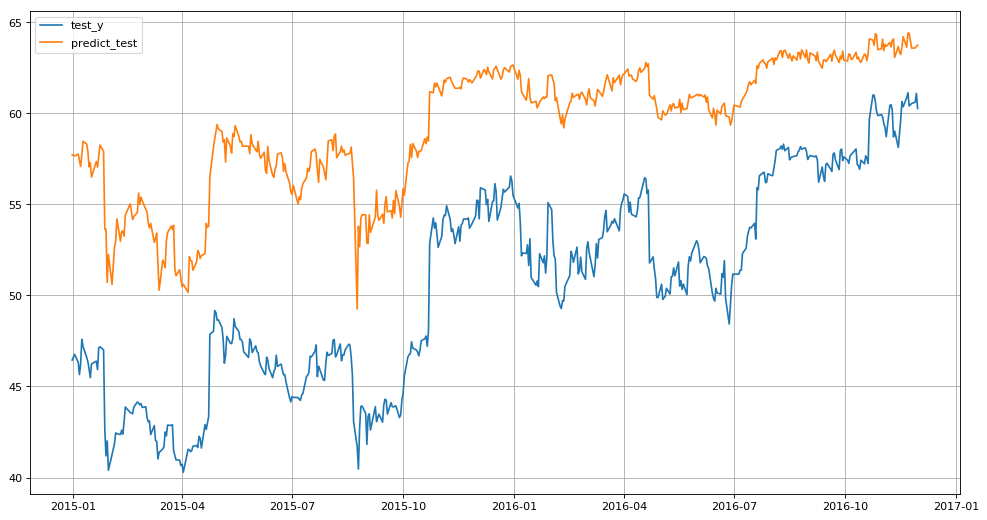

In [67]:
%matplotlib inline
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in micro['Date']]

plt.plot(index[2033:],np.squeeze(test_y,axis=1), label='test_y')
plt.plot(index[2033:],np.squeeze(predict,axis=1), label='predict_test')
plt.grid()
plt.legend()
_ = plt.ylim()

Score of baseline model

In [54]:
(abs(np.squeeze(test_y,axis=1)-np.squeeze(predict,axis=1))/np.squeeze(test_y,axis=1)).sum()

87.54984492698226

Prediction on the training data.

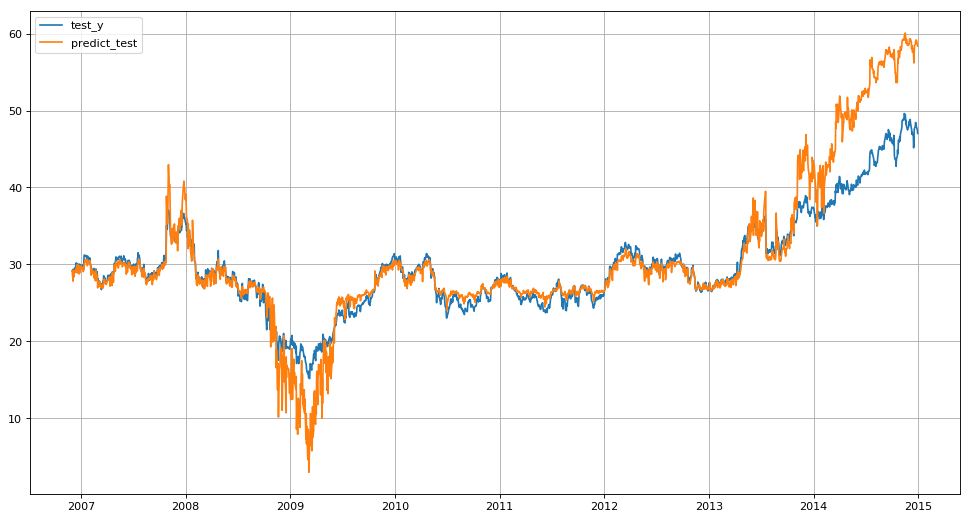

In [57]:
%matplotlib inline
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in micro['Date']]

plt.plot(index[:2033] ,np.squeeze(train_y,axis=1), label='test_y')
plt.plot(index[:2033] ,np.squeeze(model.predict(train_x),axis=1), label='predict_test')
plt.grid()
plt.legend()
_ = plt.ylim()

### Refined Model (Final)

In [68]:
# make model
model=Sequential()

# layer 1
model.add(LSTM(128,input_shape=(1,train_x.shape[2:][0]),activation='relu', return_sequences=True ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 2
model.add(LSTM(128, return_sequences=True ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 3
model.add(LSTM(128, activation='relu',return_sequences=False ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 4
model.add(Dense(200,activation='relu' ))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 5
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# layer 6
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# final output in 1
model.add(Dense(1))

In [69]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 1, 128)            69120     
_________________________________________________________________
dropout_25 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 1, 128)            512       
_________________________________________________________________
lstm_14 (LSTM)               (None, 1, 128)            131584    
_________________________________________________________________
dropout_26 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 1, 128)            512       
_________________________________________________________________
lstm_15 (LSTM)               (None, 128)               131584    
__________

####  optimise the model

In [70]:
# make optimiser
# opt=tf.keras.optimizers.Adam(lr=0.001, decay=1e-5)
# opt=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)
# opt=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0)
opt=keras.optimizers.RMSprop(lr=0.0005,rho=0.9, decay=0.0)

# compile the model
model.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])

# data log for tensorboard
time=datetime.now()
tbCallBack = keras.callbacks.TensorBoard(log_dir='/log/micro'+str(time), write_graph=True)

# model checkpoints
filepath="micro_weights_simple.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint,tbCallBack]

### Simple training of fianl model

In [71]:
# train the model
model.fit(
        train_x
        ,train_y
        , epochs=80
        ,batch_size=50
    
        ,verbose=1
        ,validation_split=0.1 
        ,callbacks=callbacks_list
        )

Train on 1829 samples, validate on 204 samples
Epoch 1/80
1829/1829 [==============================] - 5s 3ms/step - loss: 800.5214 - acc: 0.0000e+00 - val_loss: 1924.9945 - val_acc: 0.0000e+00
Epoch 2/80
1829/1829 [==============================] - 1s 637us/step - loss: 781.5788 - acc: 0.0000e+00 - val_loss: 1931.7975 - val_acc: 0.0000e+00
Epoch 3/80
1829/1829 [==============================] - 1s 677us/step - loss: 765.9410 - acc: 0.0000e+00 - val_loss: 1908.1981 - val_acc: 0.0000e+00
Epoch 4/80
1829/1829 [==============================] - 1s 650us/step - loss: 749.3932 - acc: 0.0000e+00 - val_loss: 1892.4603 - val_acc: 0.0000e+00
Epoch 5/80
1829/1829 [==============================] - 1s 659us/step - loss: 732.2260 - acc: 0.0000e+00 - val_loss: 1866.8949 - val_acc: 0.0000e+00
Epoch 6/80
1829/1829 [==============================] - 1s 658us/step - loss: 713.1683 - acc: 0.0000e+00 - val_loss: 1832.4288 - val_acc: 0.0000e+00
Epoch 7/80
1829/1829 [==============================] - 1s 70

Epoch 25/80
1829/1829 [==============================] - 1s 506us/step - loss: 185.5045 - acc: 0.0000e+00 - val_loss: 197.7365 - val_acc: 0.0000e+00
Epoch 26/80
1829/1829 [==============================] - 1s 584us/step - loss: 159.9126 - acc: 0.0000e+00 - val_loss: 100.8615 - val_acc: 0.0000e+00
Epoch 27/80
1829/1829 [==============================] - 1s 552us/step - loss: 135.2297 - acc: 0.0000e+00 - val_loss: 54.7136 - val_acc: 0.0000e+00
Epoch 28/80
1829/1829 [==============================] - 1s 567us/step - loss: 112.0746 - acc: 0.0000e+00 - val_loss: 29.0530 - val_acc: 0.0000e+00
Epoch 29/80
1829/1829 [==============================] - 1s 542us/step - loss: 90.0294 - acc: 0.0000e+00 - val_loss: 41.1260 - val_acc: 0.0000e+00
Epoch 30/80
1829/1829 [==============================] - 1s 498us/step - loss: 70.1296 - acc: 0.0000e+00 - val_loss: 60.8959 - val_acc: 0.0000e+00
Epoch 31/80
1829/1829 [==============================] - 1s 508us/step - loss: 53.6363 - acc: 0.0000e+00 - val_l

Epoch 54/80
1829/1829 [==============================] - 1s 570us/step - loss: 5.1663 - acc: 0.0044 - val_loss: 6.0351 - val_acc: 0.0000e+00
Epoch 55/80
1829/1829 [==============================] - 1s 577us/step - loss: 5.1487 - acc: 0.0060 - val_loss: 0.5039 - val_acc: 0.0098
Epoch 56/80
1829/1829 [==============================] - 1s 523us/step - loss: 5.5488 - acc: 0.0060 - val_loss: 21.2638 - val_acc: 0.0000e+00
Epoch 57/80
1829/1829 [==============================] - 1s 515us/step - loss: 5.2317 - acc: 0.0055 - val_loss: 4.3256 - val_acc: 0.0000e+00
Epoch 58/80
1829/1829 [==============================] - 1s 500us/step - loss: 5.1846 - acc: 0.0038 - val_loss: 0.8519 - val_acc: 0.0049
Epoch 59/80
1829/1829 [==============================] - 1s 548us/step - loss: 4.8427 - acc: 0.0055 - val_loss: 0.4583 - val_acc: 0.0049
Epoch 60/80
1829/1829 [==============================] - 1s 511us/step - loss: 5.3317 - acc: 0.0033 - val_loss: 0.9177 - val_acc: 0.0049
Epoch 61/80
1829/1829 [=====

#### Test the model

In [72]:
predict=model.predict(test_x)

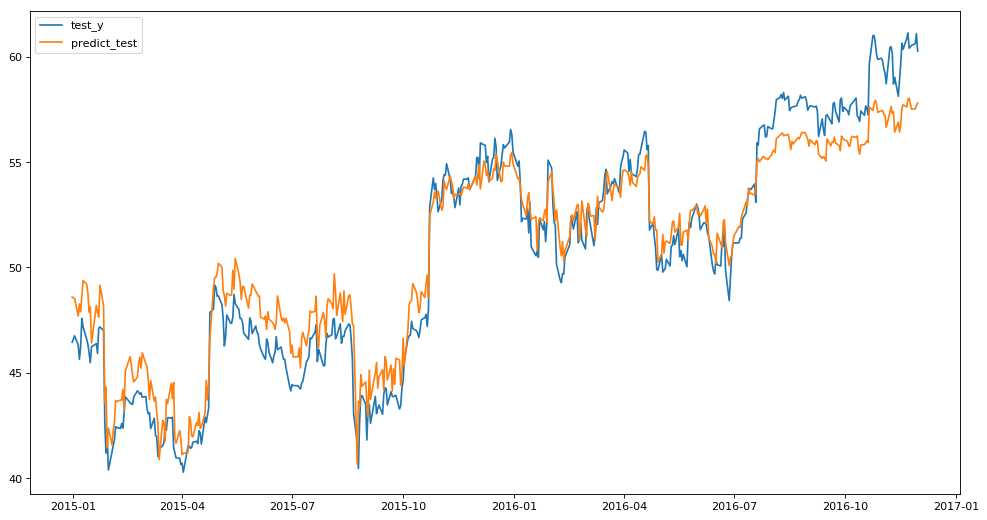

In [76]:
%matplotlib inline
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in micro['Date']]

plt.plot(index[2033:],np.squeeze(test_y,axis=1), label='test_y')
plt.plot(index[2033:],np.squeeze(predict,axis=1), label='predict_test')
# plt.grid()
plt.legend()
_ = plt.ylim()

#### Final score of the model

In [74]:
(abs(np.squeeze(test_y,axis=1)-np.squeeze(predict,axis=1))/np.squeeze(test_y,axis=1)).sum()

11.776078050535979

#### prediction on the training data

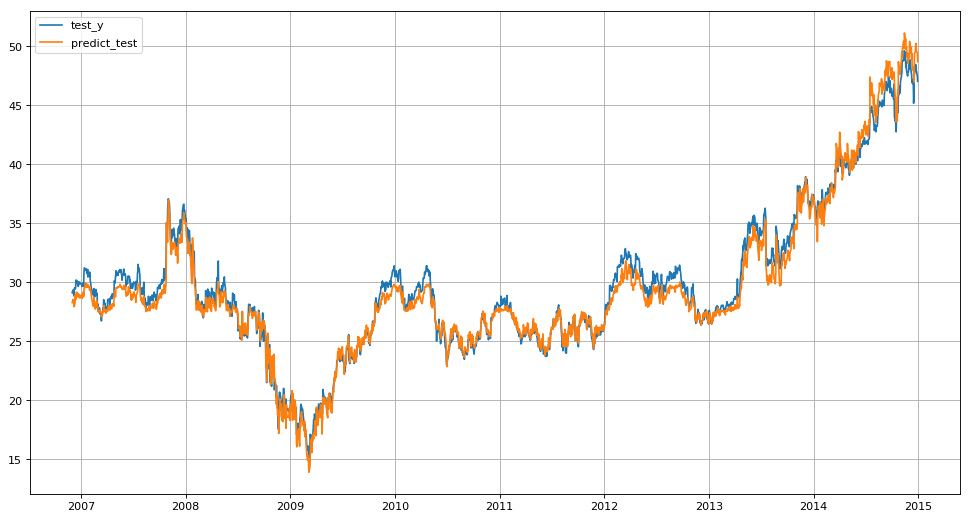

In [75]:
%matplotlib inline
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in micro['Date']]

plt.plot(index[:2033] ,np.squeeze(train_y,axis=1), label='test_y')
plt.plot(index[:2033] ,np.squeeze(model.predict(train_x),axis=1), label='predict_test')
plt.grid()
plt.legend()
_ = plt.ylim()

### Framed training

#### compile model

In [ ]:
# make optimiser
# opt=tf.keras.optimizers.Adam(lr=0.001, decay=1e-5)
# opt=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0)
# opt=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0)
opt=keras.optimizers.RMSprop(lr=0.0005,rho=0.9, decay=0.0)

# compile the model
model.compile(optimizer=opt, loss='mean_squared_error',metrics=['accuracy'])

# data log for tensorboard
time=datetime.now()
tbCallBack = keras.callbacks.TensorBoard(log_dir='/log/micro'+str(time), write_graph=True)

# model checkpoints
filepath="micro_weights_framed.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint,tbCallBack]

#### train the model

In [42]:
l=len(train_x)
frame=int(l*0.40)
shift=int(l*.1)
start=0
brake=False
end_frame=False
step=0
while brake==False:
    if start+frame<l:
        step+=1
        print(step,'  :::::::::::::::::::::::::::::::::::::::::::::')
        X=train_x[start:start+frame]
        Y=train_y[start:start+frame]
        model.fit(
                    X
                    ,Y
                    , epochs=30
                    ,batch_size=50

                    ,verbose=1
                    ,validation_split=0.1 
                    ,callbacks=callbacks_list
                    )
        start=start+shift
    
    else:
        
        if end_frame==True:
            step+=1
            print(step,start,'end train  :::::::::::::::::::::::::::::::::::::::::::::')
            X=train_x[start:]
            Y=train_y[start:]
            if len(X)>0:
                model.fit(
                        X
                        ,Y
                        , epochs=20
                        ,batch_size=50

                        ,verbose=1
                        ,validation_split=0.1 
                        ,callbacks=callbacks_list
                        )
            brake=True
        else:
            step+=1
            print(step,start,'end frame  :::::::::::::::::::::::::::::::::::::::::::::')
            X=train_x[start:]
            Y=train_y[start:]
            if len(X)>0:
                model.fit(
                        X
                        ,Y
                        , epochs=30
                        ,batch_size=50

                        ,verbose=1
                        ,validation_split=0.1 
                        ,callbacks=callbacks_list
                        )
            start=start+shift
            end_frame=True

1   :::::::::::::::::::::::::::::::::::::::::::::
Train on 731 samples, validate on 82 samples
Epoch 1/30
731/731 [==============================] - 3s 4ms/step - loss: 722.0187 - acc: 0.0000e+00 - val_loss: 863.6335 - val_acc: 0.0000e+00
Epoch 2/30
731/731 [==============================] - 1s 1ms/step - loss: 709.1871 - acc: 0.0000e+00 - val_loss: 858.2650 - val_acc: 0.0000e+00
Epoch 3/30
731/731 [==============================] - 1s 1ms/step - loss: 702.0338 - acc: 0.0000e+00 - val_loss: 851.9476 - val_acc: 0.0000e+00
Epoch 4/30
731/731 [==============================] - 1s 942us/step - loss: 695.7649 - acc: 0.0000e+00 - val_loss: 845.1482 - val_acc: 0.0000e+00
Epoch 5/30
731/731 [==============================] - 1s 913us/step - loss: 689.5444 - acc: 0.0000e+00 - val_loss: 837.3969 - val_acc: 0.0000e+00
Epoch 6/30
731/731 [==============================] - 1s 889us/step - loss: 683.7612 - acc: 0.0000e+00 - val_loss: 827.1798 - val_acc: 0.0000e+00
Epoch 7/30
731/731 [===============

731/731 [==============================] - 0s 683us/step - loss: 533.7819 - acc: 0.0000e+00 - val_loss: 634.2158 - val_acc: 0.0000e+00
Epoch 26/30
731/731 [==============================] - 1s 763us/step - loss: 523.7324 - acc: 0.0000e+00 - val_loss: 637.1785 - val_acc: 0.0000e+00
Epoch 27/30
731/731 [==============================] - 1s 747us/step - loss: 513.6241 - acc: 0.0000e+00 - val_loss: 616.4932 - val_acc: 0.0000e+00
Epoch 28/30
731/731 [==============================] - 1s 688us/step - loss: 504.0759 - acc: 0.0000e+00 - val_loss: 603.3563 - val_acc: 0.0000e+00
Epoch 29/30
731/731 [==============================] - 1s 697us/step - loss: 493.2737 - acc: 0.0000e+00 - val_loss: 590.1619 - val_acc: 0.0000e+00
Epoch 30/30
731/731 [==============================] - 1s 709us/step - loss: 482.8729 - acc: 0.0000e+00 - val_loss: 573.7678 - val_acc: 0.0000e+00
2   :::::::::::::::::::::::::::::::::::::::::::::
Train on 731 samples, validate on 82 samples
Epoch 1/30
731/731 [===============

731/731 [==============================] - 1s 699us/step - loss: 248.8484 - acc: 0.0000e+00 - val_loss: 237.2214 - val_acc: 0.0000e+00
Epoch 21/30
731/731 [==============================] - 1s 686us/step - loss: 237.7414 - acc: 0.0000e+00 - val_loss: 232.6226 - val_acc: 0.0000e+00
Epoch 22/30
731/731 [==============================] - 1s 970us/step - loss: 226.4055 - acc: 0.0000e+00 - val_loss: 219.3275 - val_acc: 0.0000e+00
Epoch 23/30
731/731 [==============================] - 1s 950us/step - loss: 216.3948 - acc: 0.0000e+00 - val_loss: 215.8555 - val_acc: 0.0000e+00
Epoch 24/30
731/731 [==============================] - 1s 847us/step - loss: 205.9049 - acc: 0.0000e+00 - val_loss: 203.8990 - val_acc: 0.0000e+00
Epoch 25/30
731/731 [==============================] - 1s 955us/step - loss: 194.9364 - acc: 0.0000e+00 - val_loss: 188.5677 - val_acc: 0.0000e+00
Epoch 26/30
731/731 [==============================] - 1s 916us/step - loss: 184.5892 - acc: 0.0000e+00 - val_loss: 176.2947 - val

Epoch 15/30
731/731 [==============================] - 1s 698us/step - loss: 22.5969 - acc: 0.0000e+00 - val_loss: 18.6506 - val_acc: 0.0000e+00
Epoch 16/30
731/731 [==============================] - 1s 686us/step - loss: 19.9059 - acc: 0.0000e+00 - val_loss: 15.7821 - val_acc: 0.0000e+00
Epoch 17/30
731/731 [==============================] - 1s 1ms/step - loss: 15.8653 - acc: 0.0014 - val_loss: 10.2862 - val_acc: 0.0000e+00
Epoch 18/30
731/731 [==============================] - 1s 1ms/step - loss: 13.6138 - acc: 0.0000e+00 - val_loss: 7.5533 - val_acc: 0.0000e+00
Epoch 19/30
731/731 [==============================] - 1s 729us/step - loss: 11.2033 - acc: 0.0014 - val_loss: 5.6599 - val_acc: 0.0000e+00
Epoch 20/30
731/731 [==============================] - 1s 693us/step - loss: 10.4373 - acc: 0.0027 - val_loss: 3.7551 - val_acc: 0.0000e+00
Epoch 21/30
731/731 [==============================] - 1s 704us/step - loss: 7.7416 - acc: 0.0000e+00 - val_loss: 1.9200 - val_acc: 0.0000e+00
Epoch 

Epoch 14/30
731/731 [==============================] - 0s 626us/step - loss: 5.5810 - acc: 0.0082 - val_loss: 1.3041 - val_acc: 0.0122
Epoch 15/30
731/731 [==============================] - 0s 569us/step - loss: 5.8708 - acc: 0.0068 - val_loss: 1.3433 - val_acc: 0.0000e+00
Epoch 16/30
731/731 [==============================] - 0s 611us/step - loss: 4.9043 - acc: 0.0082 - val_loss: 1.3134 - val_acc: 0.0122
Epoch 17/30
731/731 [==============================] - 1s 690us/step - loss: 4.9333 - acc: 0.0082 - val_loss: 1.0657 - val_acc: 0.0000e+00
Epoch 18/30
731/731 [==============================] - 0s 609us/step - loss: 4.5167 - acc: 0.0082 - val_loss: 0.3366 - val_acc: 0.0122
Epoch 19/30
731/731 [==============================] - 0s 598us/step - loss: 4.9312 - acc: 0.0082 - val_loss: 1.0208 - val_acc: 0.0000e+00
Epoch 20/30
731/731 [==============================] - 0s 597us/step - loss: 5.1841 - acc: 0.0055 - val_loss: 0.4701 - val_acc: 0.0122
Epoch 21/30
731/731 [======================

731/731 [==============================] - 0s 621us/step - loss: 3.4880 - acc: 0.0055 - val_loss: 0.5018 - val_acc: 0.0122
Epoch 17/30
731/731 [==============================] - 0s 609us/step - loss: 4.0014 - acc: 0.0041 - val_loss: 0.3142 - val_acc: 0.0122
Epoch 18/30
731/731 [==============================] - 0s 581us/step - loss: 4.3604 - acc: 0.0027 - val_loss: 0.5865 - val_acc: 0.0122
Epoch 19/30
731/731 [==============================] - 1s 699us/step - loss: 3.6553 - acc: 0.0055 - val_loss: 0.6054 - val_acc: 0.0122
Epoch 20/30
731/731 [==============================] - 0s 621us/step - loss: 4.0181 - acc: 0.0068 - val_loss: 0.8560 - val_acc: 0.0122
Epoch 21/30
731/731 [==============================] - 0s 676us/step - loss: 3.3169 - acc: 0.0055 - val_loss: 1.0465 - val_acc: 0.0122
Epoch 22/30
731/731 [==============================] - 0s 602us/step - loss: 3.0308 - acc: 0.0041 - val_loss: 0.8320 - val_acc: 0.0122
Epoch 23/30
731/731 [==============================] - 0s 606us/ste

Epoch 18/30
731/731 [==============================] - 0s 600us/step - loss: 3.5806 - acc: 0.0041 - val_loss: 1.2228 - val_acc: 0.0000e+00
Epoch 19/30
731/731 [==============================] - 0s 640us/step - loss: 3.1223 - acc: 0.0055 - val_loss: 1.4805 - val_acc: 0.0000e+00
Epoch 20/30
731/731 [==============================] - 0s 592us/step - loss: 3.0275 - acc: 0.0027 - val_loss: 1.5378 - val_acc: 0.0000e+00
Epoch 21/30
731/731 [==============================] - 0s 644us/step - loss: 3.4486 - acc: 0.0068 - val_loss: 1.5079 - val_acc: 0.0000e+00
Epoch 22/30
731/731 [==============================] - 0s 607us/step - loss: 3.1657 - acc: 0.0027 - val_loss: 0.8224 - val_acc: 0.0000e+00
Epoch 23/30
731/731 [==============================] - 0s 610us/step - loss: 3.3874 - acc: 0.0041 - val_loss: 0.4487 - val_acc: 0.0000e+00
Epoch 24/30
731/731 [==============================] - 0s 602us/step - loss: 3.1852 - acc: 0.0055 - val_loss: 4.3258 - val_acc: 0.0000e+00
Epoch 25/30
731/731 [======

Epoch 20/30
731/731 [==============================] - 0s 459us/step - loss: 3.8080 - acc: 0.0068 - val_loss: 15.5991 - val_acc: 0.0000e+00
Epoch 21/30
731/731 [==============================] - 0s 502us/step - loss: 4.0032 - acc: 0.0041 - val_loss: 16.0156 - val_acc: 0.0000e+00
Epoch 22/30
731/731 [==============================] - 0s 486us/step - loss: 3.3155 - acc: 0.0096 - val_loss: 9.2955 - val_acc: 0.0000e+00
Epoch 23/30
731/731 [==============================] - 0s 474us/step - loss: 3.5476 - acc: 0.0027 - val_loss: 10.7799 - val_acc: 0.0000e+00
Epoch 24/30
731/731 [==============================] - 0s 532us/step - loss: 4.3408 - acc: 0.0000e+00 - val_loss: 7.1736 - val_acc: 0.0000e+00
Epoch 25/30
731/731 [==============================] - 0s 502us/step - loss: 3.3251 - acc: 0.0041 - val_loss: 11.5172 - val_acc: 0.0000e+00
Epoch 26/30
731/731 [==============================] - 0s 485us/step - loss: 4.0825 - acc: 0.0068 - val_loss: 7.5362 - val_acc: 0.0000e+00
Epoch 27/30
731/731

Epoch 1/30
368/368 [==============================] - 0s 501us/step - loss: 16.7752 - acc: 0.0000e+00 - val_loss: 2.3545 - val_acc: 0.0000e+00
Epoch 2/30
368/368 [==============================] - 0s 476us/step - loss: 13.4126 - acc: 0.0000e+00 - val_loss: 6.1731 - val_acc: 0.0000e+00
Epoch 3/30
368/368 [==============================] - 0s 512us/step - loss: 11.8385 - acc: 0.0027 - val_loss: 10.2884 - val_acc: 0.0000e+00
Epoch 4/30
368/368 [==============================] - 0s 543us/step - loss: 9.9152 - acc: 0.0027 - val_loss: 12.5121 - val_acc: 0.0000e+00
Epoch 5/30
368/368 [==============================] - 0s 505us/step - loss: 8.1163 - acc: 0.0000e+00 - val_loss: 14.9210 - val_acc: 0.0000e+00
Epoch 6/30
368/368 [==============================] - 0s 485us/step - loss: 6.5459 - acc: 0.0000e+00 - val_loss: 13.1295 - val_acc: 0.0000e+00
Epoch 7/30
368/368 [==============================] - 0s 627us/step - loss: 5.5085 - acc: 0.0000e+00 - val_loss: 8.1863 - val_acc: 0.0000e+00
Epoch 8

#### test the model

In [43]:
predict=model.predict(test_x)

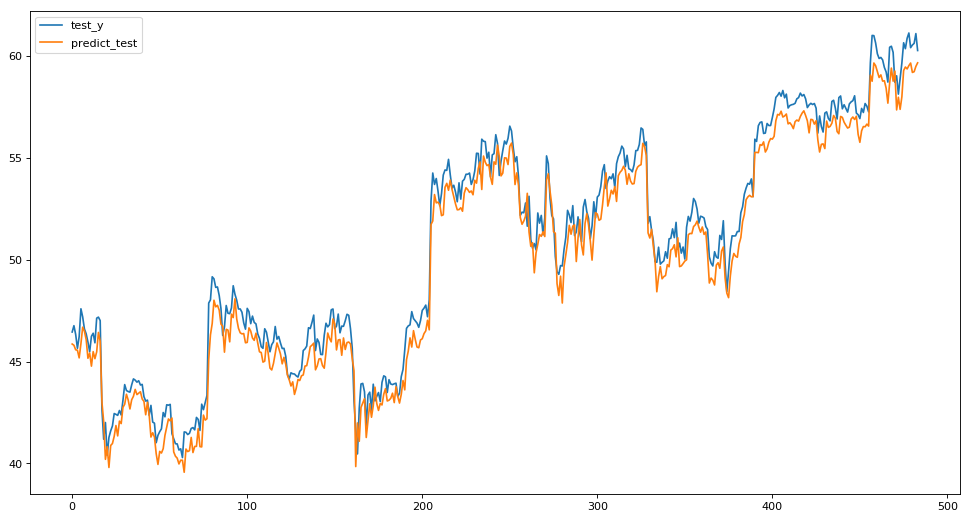

In [47]:
%matplotlib inline
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in micro['Date']]

plt.plot(index[2033:],np.squeeze(test_y,axis=1), label='test_y')
plt.plot(index[2033:],np.squeeze(predict,axis=1), label='predict_test')
plt.grid()
plt.legend()
_ = plt.ylim()

#### Score of the model

In [48]:
(abs(np.squeeze(test_y,axis=1)-np.squeeze(predict,axis=1))/np.squeeze(test_y,axis=1)).sum()

8.403493242146356

#### prediction on the training data

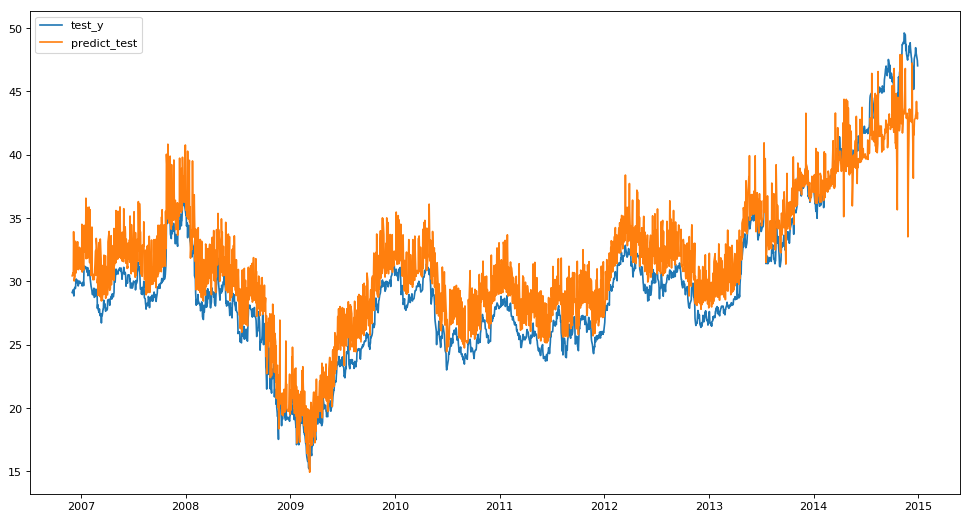

In [35]:
%matplotlib inline
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')

index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in micro['Date']]

plt.plot(index[:2033] ,np.squeeze(train_y,axis=1), label='test_y')
plt.plot(index[:2033] ,np.squeeze(model.predict(train_x),axis=1), label='predict_test')
plt.grid()
plt.legend()
_ = plt.ylim()